In [1]:
# open training file
# link to file with names: https://github.com/karpathy/makemore/blob/master/names.txt
from google.colab import drive
import torch
import numpy as np
import torch.nn.functional as F

import matplotlib.pyplot as plt
import random

drive.mount('/content/drive')

file_path = 'drive/MyDrive/Colab Notebooks/models/names.txt'
words = open(file_path, 'r').read().splitlines()

Mounted at /content/drive


In [2]:
# genereting tokens
tokens = []

for word in words:
  for letter in word:
    if letter not in tokens:
      tokens.append(letter)

tokens.sort()
tokens = ["."] + tokens
stoi = {}
itos = {}
for i in range(len(tokens)):
  itos[i] = tokens[i]
  stoi[tokens[i]] = i

In [3]:
# genereting training arrays
X_ar = []
Y_ar = []

prepared_words = []

for word in words:
  prepared_words.append(word + ".")

CONTEXT_LENGTH = 5
for word in prepared_words:
  context = [stoi["."]] * CONTEXT_LENGTH
  for letter in word:
    X_ar.append(context)
    Y_ar.append(stoi[letter])

    context = context[1:] + [stoi[letter]]

In [21]:
# creating parameters
g = torch.Generator().manual_seed(2)

C_dimensions = 30

C = torch.randn(len(tokens), C_dimensions, generator=g)

L1_size = 700
W1 = torch.randn(CONTEXT_LENGTH * C_dimensions, L1_size, generator=g)
B1 = torch.randn(L1_size, generator=g)

W2 = torch.randn(L1_size, len(tokens), generator=g)
B2 = torch.randn(len(tokens), generator=g)

p = [C, W1, B1, W2, B2]

for param in p:
  param.requires_grad = True

In [5]:
# dividing datasets
def build_dataset(list):
  X, Y = [], []

  for item in list:
    X.append(item[0])
    Y.append(item[1])


  return torch.tensor(X), torch.tensor(Y)

train_dat = []
for i in range(len(X_ar)):
  train_dat.append([X_ar[i], Y_ar[i]])

random.shuffle(train_dat)
n1 = int(len(X_ar) * 0.8)
n2 = int(len(X_ar) * 0.9)

X_train, Y_train = build_dataset(train_dat[:n1])
X_dev, Y_dev = build_dataset(train_dat[n1:n2])
X_val, Y_val = build_dataset(train_dat[n2:])

0 3.4407331943511963
1000 3.258129596710205
2000 3.0881359577178955
3000 4.553899765014648
4000 4.214267253875732
5000 2.925191640853882
6000 3.313596487045288
7000 5.27913761138916
8000 3.508023977279663
9000 2.681431531906128
10000 3.1377573013305664
11000 4.422557830810547
12000 3.0609514713287354
13000 2.843630075454712
14000 3.3992812633514404
15000 3.1298935413360596
16000 6.549936294555664
17000 3.5346834659576416
18000 3.324143648147583
19000 2.534226417541504


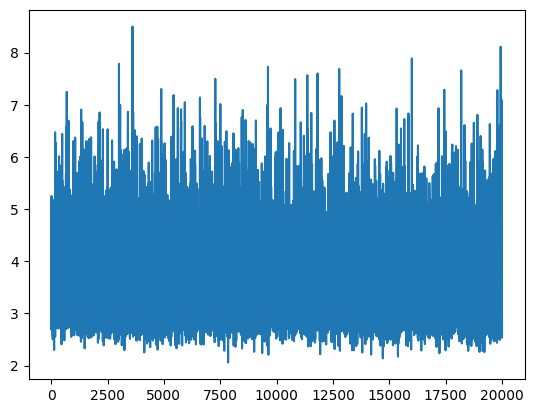

In [26]:
loss_ar = []

for k in range(20000):
  if k % 1000 == 0:
    print(k, loss.item())
  ix = torch.randint(3, X_train.shape[0], (100,))

  # forward pass
  emb = C[X_train[ix]]
  h = torch.tanh(emb.view(-1, C_dimensions * CONTEXT_LENGTH) @ W1 + B1)
  logits = h @ W2 + B2
  loss = F.cross_entropy(logits, Y_train[ix])

  # backward pass
  for param in p:
    param.grad = None
  loss.backward()
  if k < 20000:
    lr = 0.1
  else:
    lr = 0.01
  for param in p:
    param.data += -lr * param.grad

  loss_ar += [loss.item()]
plt.plot(loss_ar)

In [28]:
# test dataset
emb = C[X_dev]
h = torch.tanh(emb.view(-1, C_dimensions * CONTEXT_LENGTH) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Y_dev)
loss.item()

2.857992649078369

In [27]:
# validate dataset
emb = C[X_dev]
h = torch.tanh(emb.view(-1, C_dimensions * CONTEXT_LENGTH) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Y_dev)
loss.item()

2.857992649078369

In [ ]:
# test learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

lri = []
lri2 = []
lloss = []

for k in range(1000):
  ix = torch.randint(3, X_ar.shape[0], (100,))

  # forward pass
  emb = C[X_ar[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
  logits = h @ W2 + B2
  loss = F.cross_entropy(logits, Y_ar[ix])

  # backward pass
  for param in p:
    param.grad = None
  loss.backward()

  lr = lrs[k]
  for param in p:
    param.data -= lr * param.grad

  lri += [lre[k].item()]
  lri2 += [lrs[k].item()]
  lloss += [loss.item()]

plt.plot(lri, lloss)

In [ ]:
plt.plot(lri2, lloss)